## Import Libraries

In [63]:
from datetime import datetime
import numpy as np
import pandas as pd
from yahooquery import Ticker
import yfinance as yf
import FinanceDataReader as fdr
from fredapi import Fred
import pandas_datareader as pdr
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import ta

today = datetime.today().strftime('%Y-%m-%d')

# 1. 주가예측을 위한 범위 설정 (입력란)

In [64]:
ticker = 'aapl' # 소문자로 입력해야 합니다 아니면 FS 뽑을때 오류
start_date = '2013-09-28'
end_date = today

# 2. Technical data - 주가 수집 및 보조지표 추가

In [65]:
stock_df = yf.download(ticker, start = start_date, end = end_date)

## 2.1. SMA 단순 이평선 추가 MA = SMA
stock_df['MA5'] = stock_df['Adj Close'].rolling(window=5).mean()        # 5일 SMA
stock_df['MA20'] = stock_df['Adj Close'].rolling(window=20).mean()      # 20일 SMA
stock_df['MA60'] = stock_df['Adj Close'].rolling(window=60).mean()      # 60일 SMA
stock_df['MA120'] = stock_df['Adj Close'].rolling(window=120).mean()    # 120일 SMA

## 2.2. EMA 지수 이평선 추가 
stock_df['EMA5'] = stock_df['Adj Close'].ewm(span=5, adjust=False).mean()       # 5일 EMA
stock_df['EMA20'] = stock_df['Adj Close'].ewm(span=20, adjust=False).mean()     # 20일 EMA
stock_df['EMA60'] = stock_df['Adj Close'].ewm(span=60, adjust=False).mean()     # 60일 EMA
stock_df['EMA120'] = stock_df['Adj Close'].ewm(span=120, adjust=False).mean()   # 120일 EMA


## 2.3. 더블 볼린저 지표 추가

# 중심선 (20일 이동평균)
stock_df['BOL_AVG'] = ta.volatility.bollinger_mavg(stock_df['Adj Close'])

# 더블 볼린저 밴드 계산
stock_df['BOL_H1'] = stock_df['BOL_AVG'] + 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L1'] = stock_df['BOL_AVG'] - 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_H2'] = stock_df['BOL_AVG'] + stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L2'] = stock_df['BOL_AVG'] - stock_df['Adj Close'].rolling(window=20).std()

## 2.4. RSI (Relative Strength Index) = 상대강도지수 추가 -> RSI >70 이면 과매수 -> , RSI < 30이하면 과매도 
stock_df['RSI'] = ta.momentum.rsi(stock_df['Adj Close'])

## 2.5. MACD 추가
stock_df['MACD'] = ta.trend.macd(stock_df['Adj Close'])
stock_df['MACD_SIGNAL']= ta.trend.macd_signal(stock_df['Adj Close'])


## 2.6. OBV 추가
stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Adj Close'], stock_df['Volume'])


tech_df = stock_df

[*********************100%%**********************]  1 of 1 completed


# 3. Fundamental data - 경제지표 불러오기

In [66]:
adj_close_df = stock_df[['Adj Close']]

## 3.1. 미국 달러 환율
dxy = fdr.DataReader('DX-Y.NYB', start_date, end_date)
dxy_series = dxy['Adj Close']
DXY = dxy_series.to_frame(name='DXY.Adj Close') # Convert the Series to a DataFrame

## 3.2. 미국 국채 금리 (20년, 10년, 5년, 1년)
fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)
dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)

DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
DGS.columns = ['2-year', '5-year', '10-year']
DGS.index.name = 'Date'

## 3.3. 미국 장단기 금리차 | 금리차가 0에 가까워지거나 음수가 되면 (인버전), 이는 종종 경제의 둔화 또는 경기침체를 앞두고 있다는 시장의 예상을 반영하는 것
T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
T10Y2Y.index.name = 'Date'

## 3.4. VIX(변동 지수 %) 시장 불안정성: VIX 지수가 20을 초과하면 일반적으로 시장의 불안정성이 높다고 간주된다. | S&P 500 지수의 연간 변동성을 나타낸다 
VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
VIX.index.name = 'Date'


## 3.5. GDP - 3달주기
GDP = pd.DataFrame(fred.get_series('GDP',observation_start=start_date, observation_end = end_date),columns=['GDP'])
GDP.index.name = 'Date'


## 3.6. Unemplotment - 1달주기
Unemployment_Rate = fdr.DataReader('FRED:UNRATE', start_date, end_date)
Unemployment_Rate.index.name = 'Date'

## 3.7. CPI - 1달주기
CPI = fdr.DataReader('FRED:CPIAUCSL', start_date, end_date)
CPI.index.name = 'Date'

## 3.8. fedfunds 중앙은행 금리지표 - 1달주기
FEDFUNDS = fdr.DataReader('FRED:FEDFUNDS', start_date, end_date)
FEDFUNDS.index.name = 'Date'


## 월간 데이터들에 대한 보간법 및 Holt-Winters' Exponential Smoothing
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS], how='left')
itp_df = econ_month_df.resample('D').asfreq()

last_valid_indices = {column: itp_df[column].last_valid_index() for column in itp_df.columns} # 각 변수의 마지막 유효한 인덱스 찾기

for column in itp_df.columns:
    last_index = last_valid_indices[column]
    itp_df[column].loc[:last_index] = itp_df[column].loc[:last_index].interpolate(method='linear')

# Holt-Winters' Exponential Smoothing
forecast_steps = (pd.to_datetime(end_date) - itp_df.last_valid_index()).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.last_valid_index() + pd.Timedelta(days=1), end_date))

for column in itp_df.columns:   
    data_to_fit = itp_df[column].dropna() # 마지막 유효한 값까지의 데이터만 사용
    model = ExponentialSmoothing(data_to_fit, trend='add', seasonal=None, seasonal_periods=12).fit()
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast
    
daily_econ = pd.concat([itp_df, forecast_df])


## 3달주기인 GDP에 대한 보간법 + Holt-Winters' Exponential Smoothing
# 일별 데이터로 변환 및 보간
itp_df = GDP.resample('D').asfreq()
last_valid_index = itp_df['GDP'].last_valid_index()
itp_df['GDP'] = itp_df['GDP'].interpolate(method='linear').loc[:last_valid_index]

# Holt-Winters' Exponential Smoothing
forecast_steps = (pd.to_datetime(end_date) - itp_df.last_valid_index()).days
data_to_fit = itp_df['GDP'].dropna()
model = ExponentialSmoothing(data_to_fit, trend='add', seasonal=None, seasonal_periods=4).fit()
forecast = model.forecast(steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=['GDP'], index=pd.date_range(itp_df.last_valid_index() + pd.Timedelta(days=1), end_date))

daily_gdp = pd.concat([itp_df, forecast_df])
daily_econ = daily_econ.join([daily_gdp], how='left')

## Merge into economic data
econ_df = adj_close_df.join([DGS, T10Y2Y, VIX], how='left')
econ_df.dtypes # Check which Data types are object
econ_df = econ_df.join([daily_econ], how='left')


# 4. Fundamental data - 산업지표 불러오기

In [67]:
## 4.1. 각종 주요지표 불러오기
yf.pdr_override() ## Load 4 index data
df = pdr.get_data_yahoo("^DJI", start=start_date, end=end_date) # 다우지수
df1 = pdr.get_data_yahoo("NDAQ", start=start_date, end=end_date) # 나스닥
df2 = pdr.get_data_yahoo("^SPX", start=start_date, end=end_date) # S&P500
df3 = pdr.get_data_yahoo("^RUT", start=start_date, end=end_date) # 러셀 2000


df.rename(columns={'Adj Close': 'DJI Adj Close', 'Volume': 'DJI Volume'}, inplace=True) # 이름 다시정하기
df1.rename(columns={'Adj Close': 'NDAQ Adj Close', 'Volume': 'NDAQ Volume'}, inplace=True)
df2.rename(columns={'Adj Close': 'SPX Adj Close', 'Volume': 'SPX Volume'}, inplace=True)
df3.rename(columns={'Adj Close': 'RUT Adj Close', 'Volume': 'RUT Volume'}, inplace=True)

df = df[['DJI Adj Close', 'DJI Volume']] # 각 자료 칼럼 선택
df1 = df1[['NDAQ Adj Close', 'NDAQ Volume']]
df2 = df2[['SPX Adj Close', 'SPX Volume']]
df3 = df3[['RUT Adj Close', 'RUT Volume']]



Index_data = pd.concat([df, df1, df2, df3], axis=1, join='outer')
Index_data = Index_data.join(stock_df['Adj Close'], how='left')

## 4.2. ETF 기반 산업별 수정종가 + 거래량 데이터
sectors = {
    "VDE": "Energy",              # Vanguard Energy ETF
    "MXI": "Materials",          # iShares Global Materials ETF
    "VIS": "Industrials",        # Vanguard Industrials ETF
    "VCR": "Consumer Cyclical",  # Vanguard Consumer Discretionary ETF
    "XLP": "Consumer Staples",   # Consumer Staples Select Sector SPDR Fund
    "VHT": "Health Care",        # Vanguard Healthcare ETF
    "XLF": "Financials",         # Financial Select Sector SPDR Fund
    "VGT": "Information Technology",  # Vanguard Information Technology ETF
    "VOX": "Communication Services",  # Vanguard Communication Services ETF
    "XLU": "Utilities",          # Utilities Select Sector SPDR Fund
    "VNQ": "Real Estate"         # Vanguard Real Estate Index Fund
}
sector_data = {}


# 입력한 티커가 속한 ETF 산업군에 대한 수정종가와 거래량 매칭
for sector, sector_name in sectors.items():
    data = yf.download(sector, start=start_date, end=end_date)
    data.rename(columns={
        'Adj Close': f'{sector_name} Adj Close',
        'Volume': f'{sector_name} Volume'
    }, inplace=True) 
    sector_data[sector] = data[[f'{sector_name} Adj Close', f'{sector_name} Volume']]

ETF = pd.concat(sector_data.values(), axis=1)

## Merge into industry data
sector = yf.Ticker(ticker).info.get('sector', None)
sector_columns = [col for col in ETF.columns if sector in col] 

sector_df = ETF[sector_columns]
Industry_df = Index_data.merge(sector_df, on="Date", how="inner")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

# 5. Fundamental data - 기업 재무제표 불러오기

In [68]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
}

## 5.1. INCOME STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Income_df = pd.read_html(str(element_tables))[0] #'0번 테이블 뽑기
Income_df.to_csv(ticker+'.csv', index=False)


FS_Income = Income_df.transpose()
FS_Income.columns = FS_Income.iloc[0]
FS_Income = Income_df.set_index("Quarter Ended").transpose()
FS_Income.index.name = "Date"
FS_Income.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Income = FS_Income.iloc[:-1, :]

for column in FS_Income.columns:
    if FS_Income[column].dtype == 'object':
        FS_Income[column] = FS_Income[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x) # '-' 뒤에 숫자가 있는 문자열 처리
        if FS_Income[column].dtype == 'object' and FS_Income[column].str.contains('%').any():
            FS_Income[column] = FS_Income[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # 퍼센트 기호가 있는 문자열 처리
        FS_Income[column] = pd.to_numeric(FS_Income[column], errors='coerce')  # 다른 문자열을 숫자로 변환
        
## 5.2. RATIO STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Ratio_df = pd.read_html(str(element_tables))[0] #'0번 테이블 뽑기
Ratio_df.to_csv(ticker+'.csv', index=False)

FS_Ratio = Ratio_df.transpose()
FS_Ratio.columns = FS_Ratio.iloc[0]
FS_Ratio = Ratio_df.set_index("Quarter Ended").transpose()
FS_Ratio.index.name = "Date"
FS_Ratio.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Ratio = FS_Ratio.iloc[1:-1, :]

for column in FS_Ratio.columns:
    if FS_Ratio[column].dtype == 'object':       
        FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)             # '-' 뒤에 숫자가 있는 문자열 처리
        if FS_Ratio[column].dtype == 'object' and FS_Ratio[column].str.contains('%').any():
            FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # 퍼센트 기호가 있는 문자열 처리       
        FS_Ratio[column] = pd.to_numeric(FS_Ratio[column], errors='coerce') # 다른 문자열을 숫자로 변환

## 5.3. Balance Sheet
url = f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Balance_df = pd.read_html(str(element_tables))[0] #'0번 테이블 뽑기
Balance_df.to_csv(ticker+'.csv', index=False)

FS_Balance = Balance_df.transpose()
FS_Balance.columns = FS_Balance.iloc[0]
FS_Balance = Balance_df.set_index("Quarter Ended").transpose()
FS_Balance.index.name = "Date"
FS_Balance.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Balance = FS_Balance.iloc[:-1, :]

for column in FS_Balance.columns:
    if FS_Balance[column].dtype == 'object':       
        FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)             # '-' 뒤에 숫자가 있는 문자열 처리
        if FS_Balance[column].dtype == 'object' and FS_Balance[column].str.contains('%').any():
            FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # 퍼센트 기호가 있는 문자열 처리       
        FS_Balance[column] = pd.to_numeric(FS_Balance[column], errors='coerce') # 다른 문자열을 숫자로 변환

## 5.4. Cash Flow
url = f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Cash_df = pd.read_html(str(element_tables))[0] #'0번 테이블 뽑기
Cash_df.to_csv(ticker+'.csv', index=False)

FS_Cash = Cash_df.transpose()
FS_Cash.columns = FS_Cash.iloc[0]
FS_Cash = Cash_df.set_index("Quarter Ended").transpose()
FS_Cash.index.name = "Date"
FS_Cash.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Cash = FS_Cash.iloc[:-1, :]

for column in FS_Cash.columns:
    if FS_Cash[column].dtype == 'object':       
        FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)             # '-' 뒤에 숫자가 있는 문자열 처리
        if FS_Cash[column].dtype == 'object' and FS_Cash[column].str.contains('%').any():
            FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # 퍼센트 기호가 있는 문자열 처리       
        FS_Cash[column] = pd.to_numeric(FS_Cash[column], errors='coerce') # 다른 문자열을 숫자로 변환

In [69]:

## Create FS summary table With 보간법 & Holt-Winters' Exponential Smoothing

# BPS :FS_Balance['BPS'] = FS_Balance['Shareholders\' Equity'] / FS_Income['Shares Outstanding (Basic)']
# PBR :FS_Ratio['PBR'] = FS_Ratio['Market Capitalization'] / (FS_Balance['BPS'] * FS_Income['Shares Outstanding (Basic)'])
# PER is Ratio['PE Ratio']
# EPS is Income['EPS (Basic)'] and Income['EPS (Diluted)']
# DIV is Ratio['Dividend Yield']
# DPS is Income['Dividend Per Share']
# EBITDA is Income['EBITDA'] 

FS_Ratio['ROE'] = FS_Income['Net Income'] / FS_Balance['Shareholders\' Equity'] # ROE is Ratio['Return on Equity (ROE)']

FS_Summary = pd.concat([FS_Income, FS_Balance, FS_Ratio, FS_Cash], axis=1)

FS_Summary.index = pd.to_datetime(FS_Summary.index)
duplicated_columns = FS_Summary.columns[FS_Summary.columns.duplicated()].unique()
FS_Summary = FS_Summary.drop(columns=duplicated_columns)

# 선형보간법
itp_df = FS_Summary.resample('D').asfreq() # 일일 데이터로 리샘플링
for column in itp_df.columns:
    itp_df[column] = itp_df[column].interpolate(method='linear') # 각 변수에 대해 선형 보간법 적용
    
# Holt-Winters' Exponential Smoothing
forecast_steps = (pd.to_datetime(end_date) - itp_df.index[-1]).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), end_date)) # 예측을 저장할 데이터프레임 생성

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal= None, seasonal_periods=4).fit() # 각 변수에 대해 모델 적합 및 예측
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

daily_FS_Summary = pd.concat([itp_df, forecast_df])
daily_FS_Summary = daily_FS_Summary.dropna(axis=1, how='any') # NaN 값을 포함하는 모든 열 삭제
daily_FS_Summary
# Add Adj Close
daily_FS_Summary = daily_FS_Summary.merge(adj_close_df, left_index=True, right_index=True, how='left')
daily_FS_Summary = daily_FS_Summary.dropna()
daily_FS_Summary['Date'] = daily_FS_Summary.index
daily_FS_Summary = daily_FS_Summary.reset_index(drop=True)
daily_FS_Summary = daily_FS_Summary.set_index('Date').sort_index()


# 1.2. Select feature which correlation > 0.9 (한계: 선형 상관계수만 나타냄)
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() # 0.6 이상의 상관계수를 가진 feature들 필터링

daily_FS_Summary= daily_FS_Summary[selected_features]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## 보간법을 진행한 변수들 시각화 확인

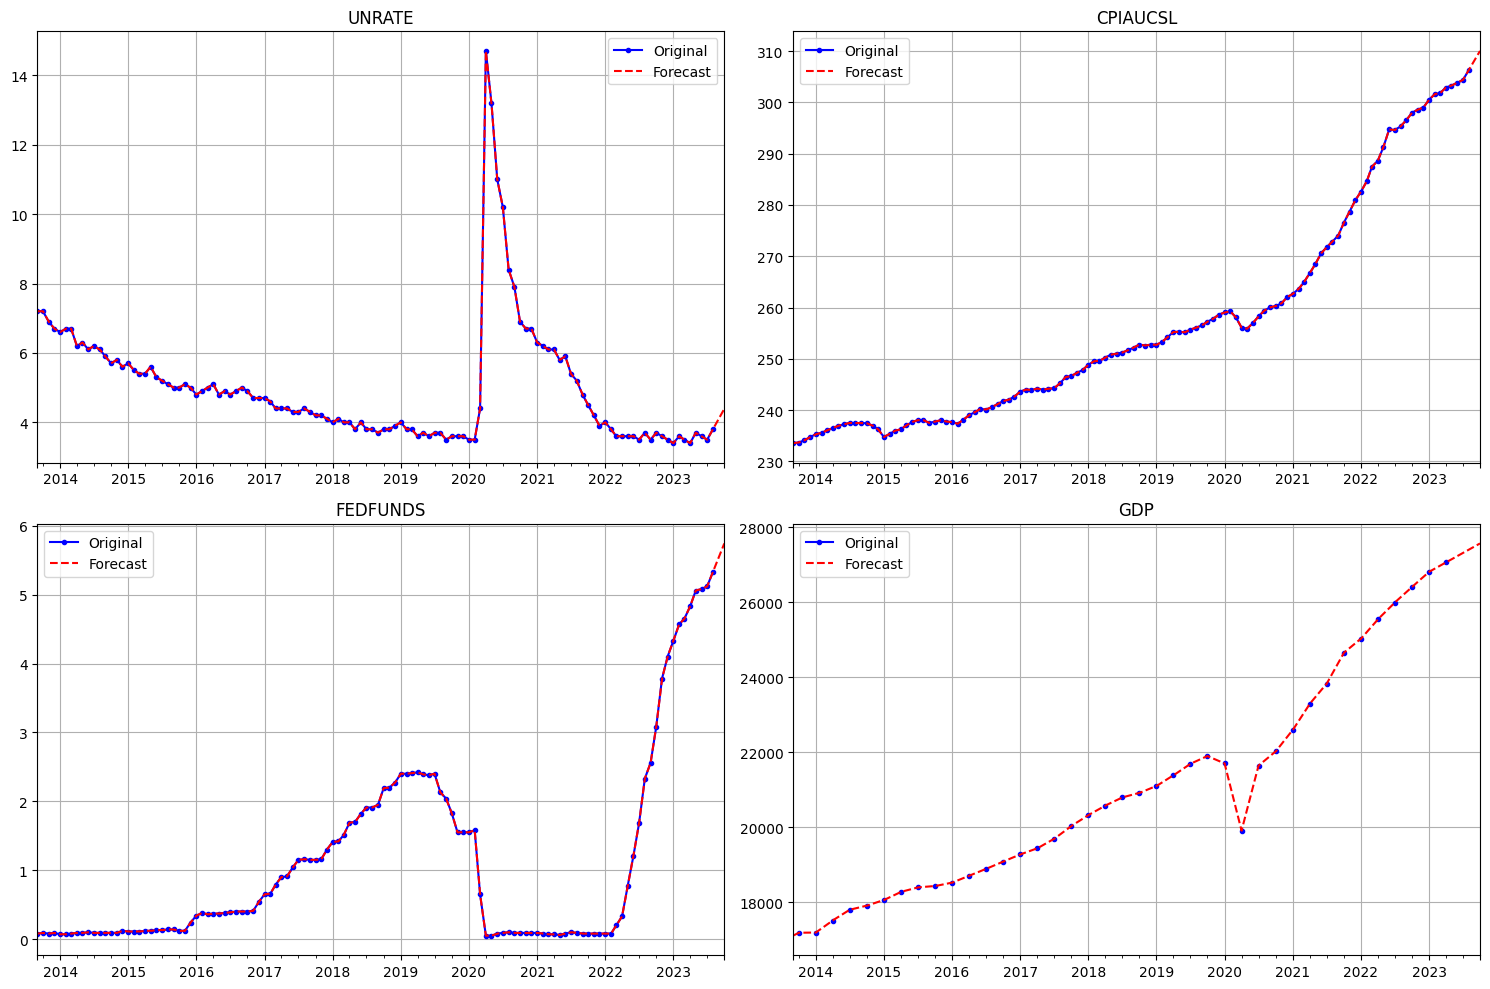

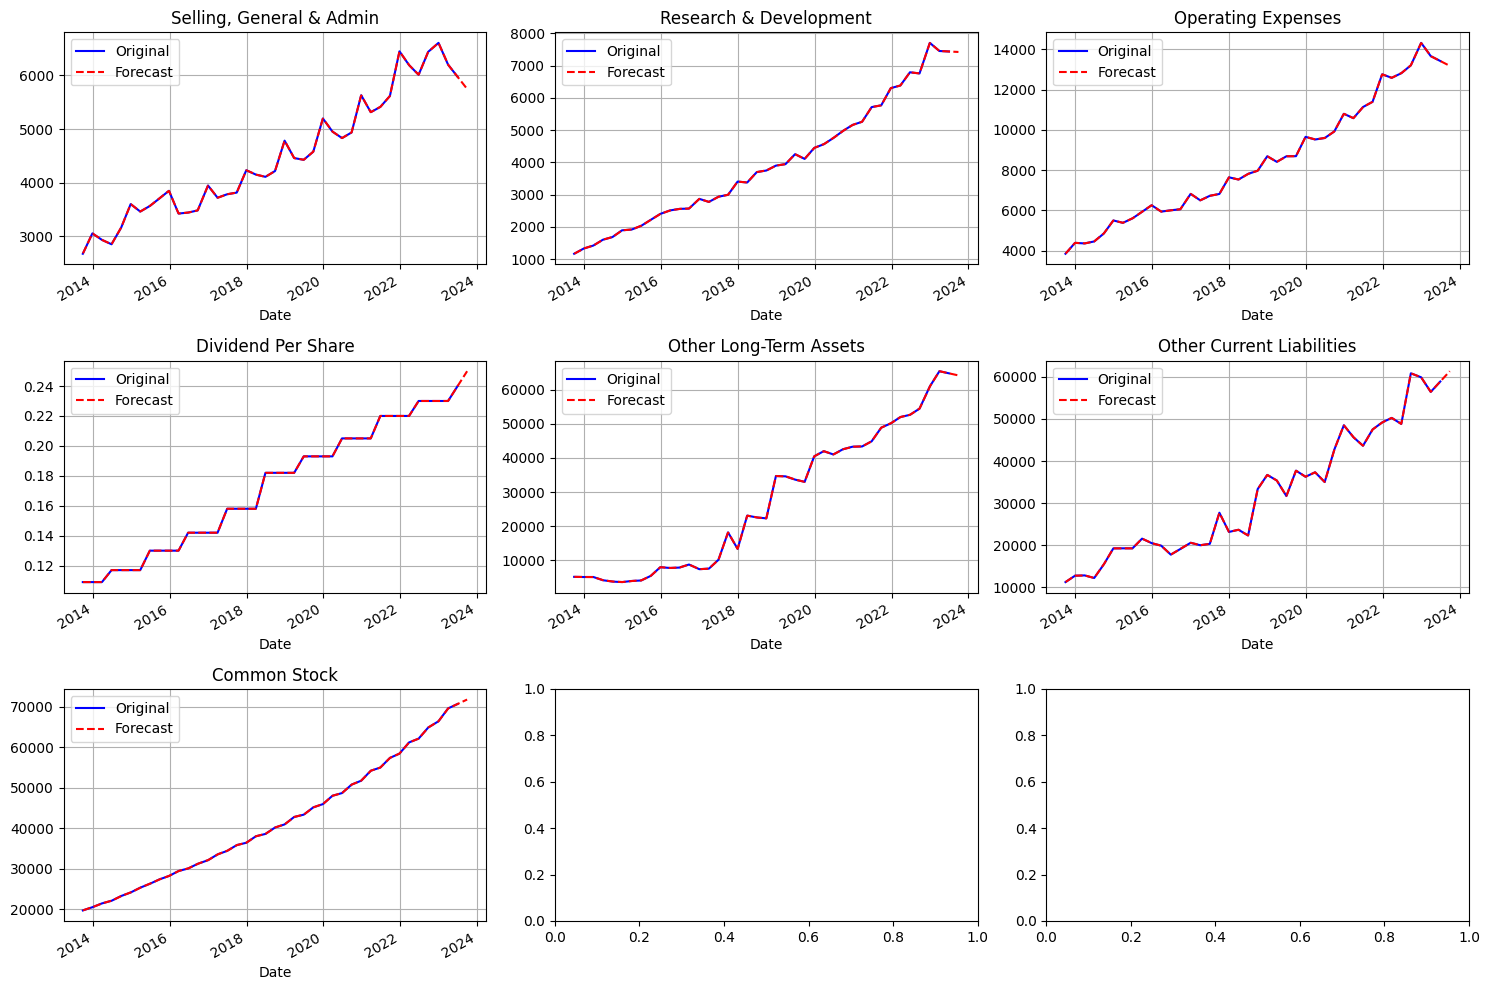

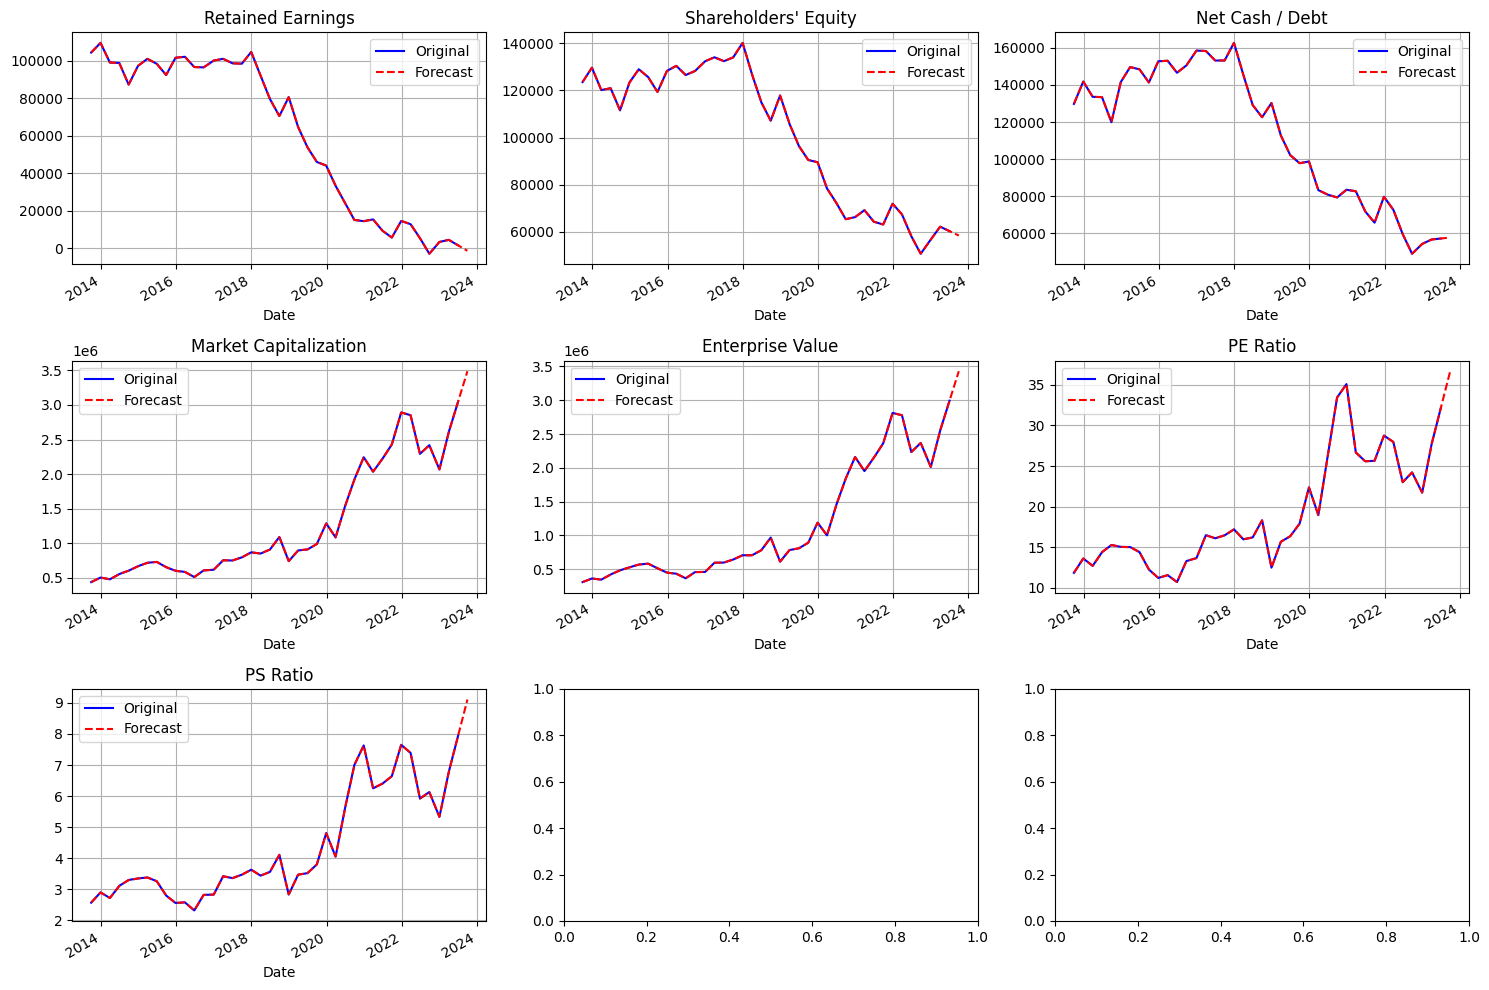

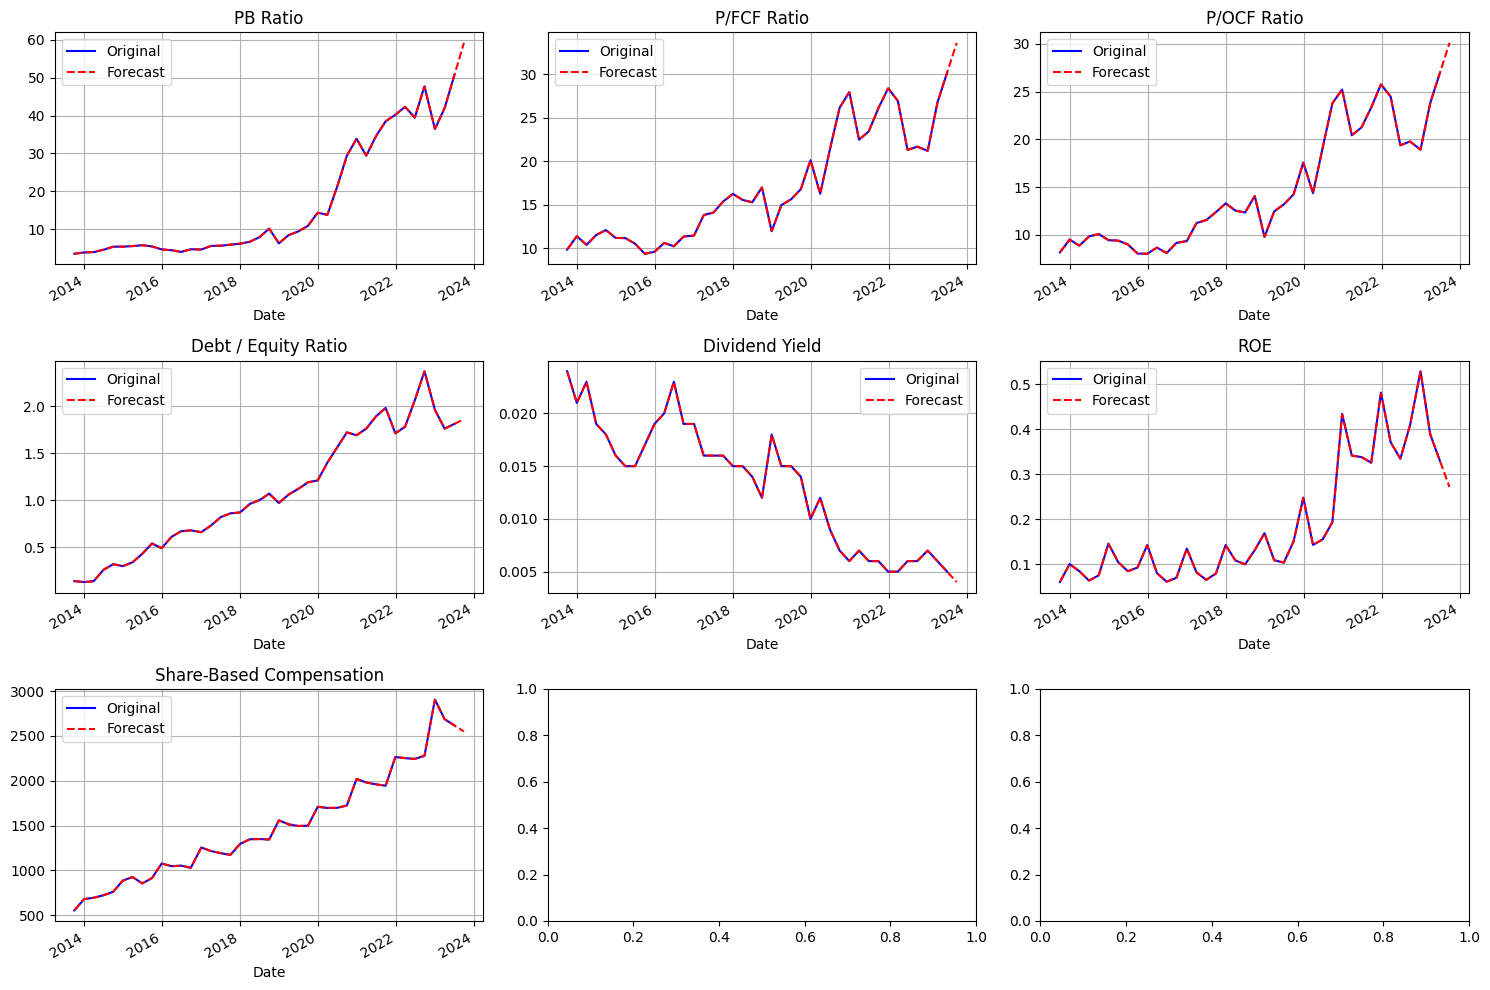

In [70]:
# 1. 경제지표 플랏비교
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS, GDP], how='left')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 subplot for 4 variables
axes = axes.ravel()

# 'econ_month_df'와 'daily_econ'의 열을 순차적으로 비교
for idx, column in enumerate(econ_month_df.columns):
    ax = axes[idx]
    econ_month_df[column].plot(ax=ax, label='Original', linestyle='-', color='blue', marker='o', ms=3)
    daily_econ[column].plot(ax=ax, label='Forecast', linestyle='--', color='red')
    ax.set_title(column)
    ax.legend(loc='best')
    ax.grid(True)
plt.tight_layout()
plt.show()

# 2. 재무제표 Summary 플랏비교

common_columns = FS_Summary.columns.intersection(daily_FS_Summary.columns) # 두 데이터 프레임에서 공통된 열만 선택
common_columns
page_size = 7
total_pages = -(-len(common_columns) // page_size)

for page in range(total_pages):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.ravel() 
    
    # 해당 페이지의 마지막 항목 인덱스 계산
    end_idx = min((page + 1) * page_size, len(common_columns))
    
    for idx in range(page * page_size, end_idx):
        column = common_columns[idx]
        FS_Summary[column].plot(ax=axes[idx % page_size], label='Original', linestyle='-', color='blue')
        daily_FS_Summary[column].plot(ax=axes[idx % page_size], label='Forecast', linestyle='--', color='red')
        axes[idx % page_size].set_title(column)
        axes[idx % page_size].legend(loc='best')
        axes[idx % page_size].grid(True)
    plt.tight_layout()
    plt.show()



## 변수들과 수정종가간의 상관관계 시각화

['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 'EMA5', 'EMA20', 'EMA60', 'EMA120', 'BOL_AVG', 'BOL_H1', 'BOL_L1', 'BOL_H2', 'BOL_L2']


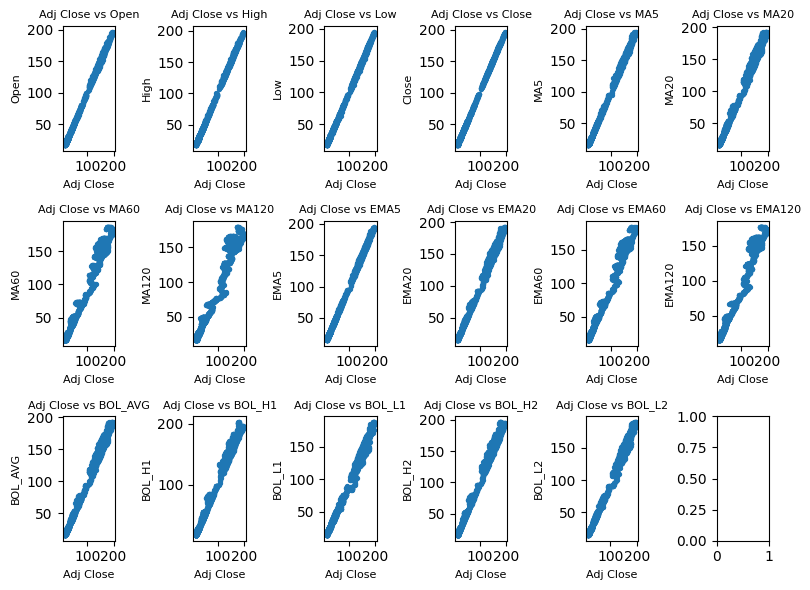

['CPIAUCSL', 'GDP']


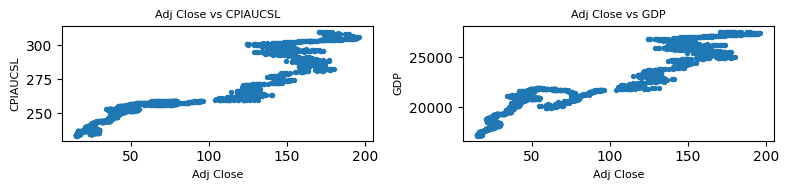

['DJI Adj Close', 'NDAQ Adj Close', 'SPX Adj Close', 'Information Technology Adj Close']


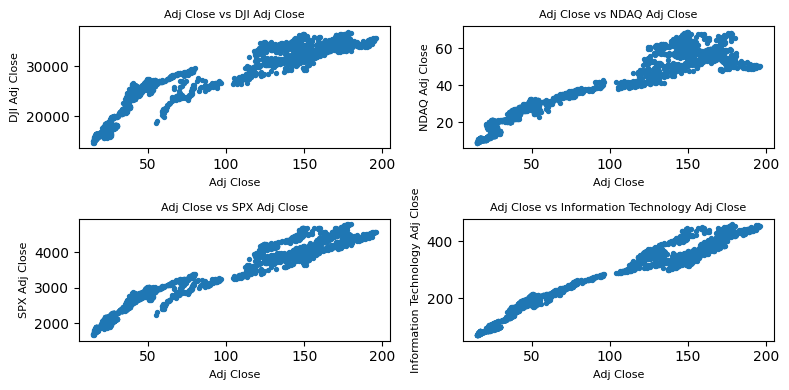

In [73]:
## Technical Variable Selection
# 1.1. Select feature which correlation > 0.9 (한계: 선형 상관계수만 나타냄)
correlation = tech_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() # 0.6 이상의 상관계수를 가진 feature들 필터링
selected_features.remove('Adj Close') # 'Adj Close' 제거
print(selected_features) # ['Open', 'High', 'Low', 'Close', 'MA5', 'MA15', 'MA75', 'MA150', 'BOL_H', 'BOL_AVG', 'BOL_L', 'OBV']

# 1.2. Correlation Graph against Adj Close
n = len(selected_features) # 총 변수 갯수에 따른 행과 열 계산
ncols = 6  # 한 행에 2개의 그래프
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features):
    ax.scatter(tech_df['Adj Close'], tech_df[feature], s=8) # s=10으로 점의 크기 줄임
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

## Economic Variable Selection
# 2.1. 
correlation = econ_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() # 0.6 이상의 상관계수를 가진 feature들 필터링
selected_features.remove('Adj Close') # 'Adj Close' 제거
print(selected_features) 

# 2.2.
n = len(selected_features) # 총 변수 갯수에 따른 행과 열 계산
ncols = 2  # 한 행에 2개의 그래프
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features):
    ax.scatter(econ_df['Adj Close'], econ_df[feature], s=8) # s=10으로 점의 크기 줄임
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()


## Industry Variable Selection
# 3.1. 
correlation = Industry_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() # 0.6 이상의 상관계수를 가진 feature들 필터링
selected_features.remove('Adj Close') # 'Adj Close' 제거
print(selected_features) 

# 3.2.
n = len(selected_features) # 총 변수 갯수에 따른 행과 열 계산
ncols = 2  # 한 행에 2개의 그래프
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features):
    ax.scatter(Industry_df['Adj Close'], Industry_df[feature], s=8) # s=10으로 점의 크기 줄임
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()


## Company Variable Selection
# 4.1. 
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() # 0.6 이상의 상관계수를 가진 feature들 필터링
selected_features.remove('Adj Close') # 'Adj Close' 제거
print(selected_features) 

# 4.2.
n = len(selected_features) # 총 변수 갯수에 따른 행과 열 계산
ncols = 6  # 한 행에 2개의 그래프
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features):
    ax.scatter(daily_FS_Summary['Adj Close'], daily_FS_Summary[feature], s=8) # s=10으로 점의 크기 줄임
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()


## 파일 저장

In [74]:

## 1. Tech indicator
save_path = f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_stock_Tech_data.csv'  
tech_df.to_csv(save_path, index=True) 

## 2. Econ indicator
save_path = f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Econ_data.csv'  
econ_df.to_csv(save_path, index=True) 

## 3. Industry indicator
save_path = '/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Industry_data.csv'  
Industry_df.to_csv(save_path, index=True) 

## 4. Company indicator
#save_path = f'dacon/final/Loaded data/{ticker}_FS_Income.csv'  
#FS_Income.to_csv(save_path, index=True) 

#save_path = f'dacon/final/Loaded data/{ticker}_FS_Ratio.csv'  
#FS_Ratio.to_csv(save_path, index=True) 

#save_path = f'dacon/final/Loaded data/{ticker}_FS_Balance.csv'  
#FS_Balance.to_csv(save_path, index=True) 

#save_path = f'dacon/final/Loaded data/{ticker}_FS_Cash.csv'  
#FS_Cash.to_csv(save_path, index=True) 

## 5. Company FS summary daily
save_path = f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_FS_summary.csv'  
daily_FS_Summary.to_csv(save_path, index=True) 
